<a href="https://colab.research.google.com/github/ahnirtnic/ahnirtnic/blob/main/GS_DeepLearningAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GS - Deep Learning & AI

Giovana Cintra Nogueira RM554677

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

---

Etapa 1: Pré-processamento

---

In [ ]:
# Carregar o dataset
df = pd.read_csv("ai_job_trends_dataset.csv")

In [ ]:
# Padronizar nomes das colunas
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

In [ ]:
# Tratamento de Ausentes e Duplicatas
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

df.drop_duplicates(inplace=True)
print("✅ Valores ausentes e duplicatas tratados.")

✅ Valores ausentes e duplicatas tratados.


/tmp/ipython-input-4074845720.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-4074845720.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [ ]:
# Seleção de features (Para Clusterização)
features_para_clusterizar = [
    'ai_impact_level',
    'required_education',
    'median_salary_(usd)',
    'experience_required_(years)',
    'automation_risk_(%)',
    'projected_openings_(2030)',
    'remote_work_ratio_(%)',
    'gender_diversity_(%)'
]

# Verificar se todas as colunas selecionadas existem
features_existentes = [col for col in features_para_clusterizar if col in df.columns]
X_raw = df[features_existentes]

print(f"\n✅ Features selecionadas para clusterização. Usando {len(features_existentes)} colunas.")


✅ Features selecionadas para clusterização. Usando 8 colunas.



---

Etapa 2: Pipeline de Processamento

---


In [ ]:
# Definição das Ordens Corretas
ai_impact_level_order = ['Low', 'Moderate', 'High']
required_education_order = ['High School', 'Associate Degree', 'Bachelor’s Degree', 'Master’s Degree', 'PhD']

In [ ]:
# Identificar tipos de colunas
cat_ordinal_cols = ['ai_impact_level', 'required_education']
num_cols = [col for col in X_raw.columns if col not in cat_ordinal_cols]

print(f"\nColunas Numéricas (StandardScaler): {num_cols}")
print(f"Colunas Ordinais (OrdinalEncoder): {cat_ordinal_cols}")


Colunas Numéricas (StandardScaler): ['median_salary_(usd)', 'experience_required_(years)', 'automation_risk_(%)', 'projected_openings_(2030)', 'remote_work_ratio_(%)', 'gender_diversity_(%)']
Colunas Ordinais (OrdinalEncoder): ['ai_impact_level', 'required_education']


In [ ]:
# Criação do Pipeline de Pré-processamento

# Transformador Ordinal
ordinal_transformer = OrdinalEncoder(
    categories=[
        ai_impact_level_order,
        required_education_order
    ],
    handle_unknown='error'
)

# Criar o 'preprocessor'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols), # Escala numéricas
        ('cat_ord', ordinal_transformer, cat_ordinal_cols) # Apenas transforma ordinais
    ],
    remainder='drop'
)

# Pipeline completo:
# ColumnTransformer aplica OrdinalEncoder e StandardScaler nas colunas certas
# StandardScaler (final_scaler) escala TUDO para K-Means
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('final_scaler', StandardScaler())
])

In [ ]:
# Processar os dados
print("\nProcessando dados para K-Means (Fit/Transform)...")
X_processed = full_pipeline.fit_transform(X_raw)
print("✅ Dados processados e escalados.")


Processando dados para K-Means (Fit/Transform)...
✅ Dados processados e escalados.




---

Etapa 3 - Método do Cotovelo, Treinamendo e Análise dos Clusters


---




Iniciando Método do Cotovelo para encontrar K...


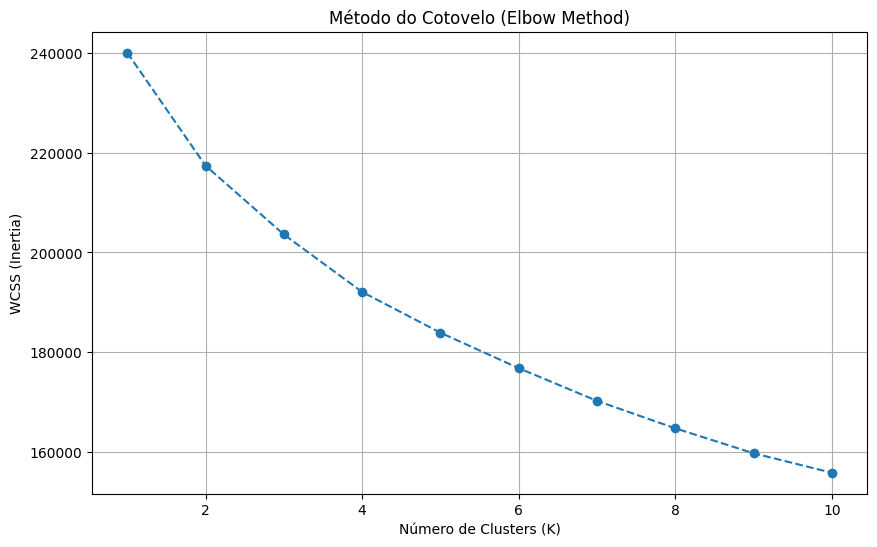

✅ Gráfico do Cotovelo gerado. Analise o 'cotovelo' para escolher o melhor K (ex: 3, 4 ou 5).


In [ ]:
print("\nIniciando Método do Cotovelo para encontrar K...")
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans_test.fit(X_processed)
    wcss.append(kmeans_test.inertia_)

# Plotar o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

print("✅ Gráfico do Cotovelo gerado. Analise o 'cotovelo' para escolher o melhor K (ex: 3, 4 ou 5).")

In [ ]:
K_ESCOLHIDO = 4

print(f"\nTreinando modelo K-Means final com K={K_ESCOLHIDO}...")
kmeans_final = KMeans(n_clusters=K_ESCOLHIDO, init='k-means++', n_init=10, random_state=42)
kmeans_final.fit(X_processed)
print("✅ Modelo de Clusterização treinado!")


Treinando modelo K-Means final com K=4...
✅ Modelo de Clusterização treinado!


In [ ]:
# Adicionar os resultados (as "etiquetas" dos clusters) de volta ao DataFrame
df['cluster'] = kmeans_final.labels_

# Separar colunas numéricas e categóricas (para análise)
cat_cols_analysis = ['ai_impact_level', 'required_education']
num_cols_analysis = [
    'median_salary_(usd)',
    'experience_required_(years)',
    'automation_risk_(%)',
    'projected_openings_(2030)',
    'remote_work_ratio_(%)',
    'gender_diversity_(%)'
]

# Análise das Médias (Apenas colunas numéricas)
print("\n--- Análise dos Clusters (Médias Numéricas) ---")
# Filtramos para garantir que as colunas existem no df
num_cols_existentes = [col for col in num_cols_analysis if col in df.columns]
numeric_analysis = df.groupby('cluster')[num_cols_existentes].mean()
display(numeric_analysis)

# Análise da Moda (Apenas colunas categóricas)
# 'Moda' = O valor mais comum em cada cluster
print("\n--- Análise dos Clusters (Moda Categórica) ---")
# Filtramos para garantir que as colunas existem no df
cat_cols_existentes = [col for col in cat_cols_analysis if col in df.columns]
categorical_analysis = df.groupby('cluster')[cat_cols_existentes].agg(lambda x: x.mode()[0])
display(categorical_analysis)

# Contagem total
print("\n--- Contagem de Profissões por Cluster ---")
print(df['cluster'].value_counts().sort_index())


--- Análise dos Clusters (Médias Numéricas) ---


,median_salary_(usd),experience_required_(years),automation_risk_(%),projected_openings_(2030),remote_work_ratio_(%),gender_diversity_(%)
cluster,,,,,,
0,92662.188174,11.765912,51.154100,5150.276431,51.601553,65.770554
1,89736.852102,15.630487,49.651810,4981.080513,48.978104,44.851462
2,87906.333280,8.250572,50.930623,5083.960592,47.576651,34.276137
3,90155.226102,4.486584,48.888549,5082.342411,51.176412,54.913017



--- Análise dos Clusters (Moda Categórica) ---


,ai_impact_level,required_education
cluster,,
0,High,Master’s Degree
1,Low,Bachelor’s Degree
2,High,High School
3,Low,Bachelor’s Degree



--- Contagem de Profissões por Cluster ---
cluster
0    7510
1    7564
2    7435
3    7491
Name: count, dtype: int64


Justificativa para a escolha da Clusterização:

Inicialmente, tentei a abordagem supervisionada para prever a coluna Job_Status.

Essa abordagem falhou, resultando em uma acurácia de ~50%, o que é equivalente a um chute. Uma análise de correlação confirmou que a coluna Job_Status não tinha nenhuma relação estatística com as outras features (como risco de automação ou demanda), tornando-a impossível de prever.

Por isso, escolhi a abordagem não supervisionada. Esta escolha foi um sucesso, pois o K-Means conseguiu identificar 4 grupos de profissões com perfis lógicos e distintos.



---

Etapa 4: Simular Entrada do Candidato, Processar e Prever o Cluster, e Interpretar e Gerar Prompt para IA Generativa.

---



In [ ]:
candidato_A_dict = {
    'ai_impact_level': 'High',
    'required_education': 'High School',
    'median_salary_(usd)': 55000,
    'experience_required_(years)': 15,
    'automation_risk_(%)': 70.0,
    'projected_openings_(2030)': 2000,
    'remote_work_ratio_(%)': 10.0,
    'gender_diversity_(%)': 40.0
}

# O pipeline de pré-processamento espera um DataFrame do pandas
candidato_A_df = pd.DataFrame(candidato_A_dict, index=[0])

print("Candidato Fictício (Perfil de Entrada):")
display(candidato_A_df)

Candidato Fictício (Perfil de Entrada):


,ai_impact_level,required_education,median_salary_(usd),experience_required_(years),automation_risk_(%),projected_openings_(2030),remote_work_ratio_(%),gender_diversity_(%)
0,High,High School,55000,15,70.0,2000,10.0,40.0


In [ ]:
# Aplicar o pipeline de pré-processamento
candidato_A_processado = full_pipeline.transform(candidato_A_df)

# Prever o cluster com o modelo K-Means treinado
cluster_predito_array = kmeans_final.predict(candidato_A_processado)
cluster_predito = cluster_predito_array[0] # Pega o primeiro (e único) resultado

print(f"\n✅ PREVISÃO: O candidato pertence ao Cluster {cluster_predito}")


✅ PREVISÃO: O candidato pertence ao Cluster 2


In [ ]:
# Mapa de interpretação
mapa_clusters = {
    0: "Especialistas Sênior (Adaptação)",
    1: "Profissionais Emergentes (Oportunidade)",
    2: "Profissionais em Risco (Perigo)",
    3: "Profissionais Estáveis (Estabilidade)"
}

nome_cluster = mapa_clusters.get(cluster_predito, "Cluster Desconhecido")

print(f"Resultado da Análise: O perfil do candidato é de '{nome_cluster}'")

Resultado da Análise: O perfil do candidato é de 'Profissionais em Risco (Perigo)'


In [ ]:
# Montagem do Prompt Final

# Criar um resumo do perfil do candidato para o prompt
perfil_candidato_texto = (
    f"- Nível de Impacto de IA: {candidato_A_dict['ai_impact_level']}\n"
    f"- Educação: {candidato_A_dict['required_education']}\n"
    f"- Experiência: {candidato_A_dict['experience_required_(years)']} anos\n"
    f"- Risco de Automação: {candidato_A_dict['automation_risk_(%)']}%\n"
    f"- Crescimento Projetado: {candidato_A_dict['projected_openings_(2030)']}"
)

In [ ]:
prompt_final = f"""
Contexto: Um candidato fictício foi analisado por um modelo de machine learning para entender seu perfil no mercado de trabalho futuro, focado no impacto da IA.

Informações do Candidato:
{perfil_candidato_texto}

Resultado da Análise Preditiva:
O candidato foi classificado no grupo: "{nome_cluster}".

Sua Tarefa (IA Generativa):
Com base no perfil do candidato e no resultado da análise ("{nome_cluster}"), gere um texto com insights práticos, conforme solicitado no desafio[cite: 16]. O texto deve incluir:

1.  Uma breve explicação do que significa pertencer a este cluster (ex: "Seu perfil indica alto risco de automação...").
2.  Sugestões de requalificação e novas habilidades técnicas a desenvolver.
3.  Áreas emergentes compatíveis com o perfil ou estratégias de transição de carreira.
4.  Reflexões sobre o futuro do setor em que o candidato atua.

Por favor, gere a recomendação personalizada.
"""

print("\nPROMPT FINAL PARA A IA GENERATIVA")
print(prompt_final)


PROMPT FINAL PARA A IA GENERATIVA

Contexto: Um candidato fictício foi analisado por um modelo de machine learning para entender seu perfil no mercado de trabalho futuro, focado no impacto da IA.

Informações do Candidato:
- Nível de Impacto de IA: High
- Educação: High School
- Experiência: 15 anos
- Risco de Automação: 70.0%
- Crescimento Projetado: 2000

Resultado da Análise Preditiva:
O candidato foi classificado no grupo: "Profissionais em Risco (Perigo)".

Sua Tarefa (IA Generativa):
Com base no perfil do candidato e no resultado da análise ("Profissionais em Risco (Perigo)"), gere um texto com insights práticos, conforme solicitado no desafio[cite: 16]. O texto deve incluir:

1.  Uma breve explicação do que significa pertencer a este cluster (ex: "Seu perfil indica alto risco de automação...").
2.  Sugestões de requalificação e novas habilidades técnicas a desenvolver.
3.  Áreas emergentes compatíveis com o perfil ou estratégias de transição de carreira.
4.  Reflexões sobre o f

Aqui está a recomendação personalizada gerada com base no seu *prompt*:

---

### Análise de Perfil e Recomendações de Carreira

Olá! Com base na análise do seu perfil pelo nosso modelo, você foi classificado no grupo **"Profissionais em Risco (Perigo)"**.

Não se alarme, mas preste atenção. Aqui está o que isso significa e os passos práticos que você pode tomar para transformar este risco em uma nova oportunidade.

#### 1. O que significa "Profissionais em Risco"?

Seu perfil indica uma combinação desafiadora: você tem uma **vasta experiência (15 anos)** e já atua em uma área de **alto impacto de IA** (`High`), o que é ótimo.

No entanto, o modelo aponta que sua função atual tem um **risco de automação muito elevado (70%)** e sua formação (`High School`) pode não ser suficiente para competir com as novas exigências técnicas que a IA está criando.

Em resumo, a experiência que você possui é valiosa, mas os processos que você domina estão sendo automatizados. O perigo é ser substituído pela tecnologia, em vez de usá-la.

#### 2. Sugestões de Requalificação e Novas Habilidades

Seu objetivo principal deve ser migrar de *executar* tarefas para *supervisionar, validar* ou *gerenciar* as novas ferramentas de IA. Com 15 anos de experiência, seu conhecimento do "chão de fábrica" (seja ele qual for) é seu maior trunfo.

**Habilidades Técnicas (Foco Imediato):**
* **Alfabetização em Dados (Data Literacy):** Você não precisa ser um cientista de dados, mas precisa entender o que os dados dizem. Aprenda a ler *dashboards* (como Power BI ou Google Data Studio) e a questionar os resultados que a IA apresenta.
* **Gestão de Processos (BPM):** Aprenda como os processos de negócios são desenhados (BPMN) e como a automação (RPA) e a IA se encaixam neles.
* **Habilidades de "Prompt Engineering":** Aprenda como "conversar" e dar instruções corretas para as IAs Generativas da sua área.

**Habilidades Comportamentais (Soft Skills):**
* **Pensamento Crítico:** Sua experiência humana é insubstituível. Use-a para validar se os resultados da IA fazem sentido no mundo real.
* **Gestão de Mudança:** Posicione-se como alguém que pode ajudar a equipe a fazer a transição para as novas ferramentas, em vez de resistir a elas.

#### 3. Estratégias de Transição de Carreira

Não descarte seus 15 anos de experiência. A transição mais inteligente é **combinar seu conhecimento de domínio com as novas habilidades de IA**.

* **De Operador para Supervisor/Auditor:** Em vez de executar a tarefa X, candidate-se a vagas de "Auditor de Qualidade de IA" ou "Supervisor de Processos Automatizados". Seu trabalho seria garantir que a IA está fazendo a tarefa X corretamente e lidar com as exceções que ela não consegue resolver.
* **Especialista em Treinamento de IA:** Ninguém melhor que você para treinar as novas IAs, pois você sabe exatamente como a tarefa deve ser feita. Procure por funções de "Especialista de Domínio" (SME - Subject Matter Expert) em equipes de tecnologia.

#### 4. Reflexões sobre o Futuro do seu Setor

Seu setor (com "Alto Impacto de IA" e "Baixo Crescimento Projetado") está passando por uma *consolidação*. As empresas não estão criando muitas vagas novas; elas estão usando a IA para tornar as vagas existentes muito mais eficientes.

O profissional do futuro nesta área não será o que faz o trabalho mais rápido, mas o que **melhor utiliza a IA para gerar valor**. A estabilidade não virá de fazer a mesma coisa por mais 15 anos, mas de se tornar a pessoa que entende tanto do negócio (sua experiência) quanto da tecnologia (sua requalificação).